## EEM20 Forecasting Competition

* the following is a mix from solutions and approaches presented in [1] and [2] in order to achieve the 1st and 2nd best performances in the EEM20 forecasting competition (more details at https://eem20.eu/forecasting-competition/ ) as well as some homemade solutions.
* no performance objective in this notebook, just a quick overview of the challenge at hand 
* some baseline results are presented at the end (using roughly 50 Mo of data retrieved from the >20Go training data available) + some plots from the 3rd best submission for task 1 

[1] Kevin Bellinguer, Valentin Mahler, Simon Camal, Georges Kariniotakis. Probabilistic Forecasting of Regional Wind Power Generation for the EEM20 Competition: a Physics-oriented Machine Learning Approach. 17th European Energy Market Conference, EEM 2020, KTH, IEEE, Sep 2020, Stockholm (by visio), Sweden. ⟨hal-02952589⟩ 

[2] J. Browell, C. Gilbert, R. Tawn and L. May, "Quantile Combination for the EEM20 Wind Power Forecasting Competition," 2020 17th International Conference on the European Energy Market (EEM), Stockholm, Sweden, 2020, pp. 1-6, doi: 10.1109/EEM49802.2020.9221942.

* The notebook is organised as follows : 
    * 1 : windfarm clustering (using only wind turbines data)
    * 2 : dimensionality reduction : selecting a few random points around clusters centers
    * 3 : numerical weather prediction (NWP) data download 
    * 4 : NWP data feature engineering
    * 5 : PCA / analog-based approach
    * 6 : model.fit / predict (gradient boosting regressor)
    * 7 : some plots : baseline results + 3rd best submission for task 1 

In [2]:
import xarray as xr
import s3fs
import pandas as pd
warnings.filterwarnings("ignore")
import os
import csv
import re 
import time
import collections
import pandas as pd
import dask.dataframe as dd
import numpy as np
from datetime import datetime
import glob
from scipy import stats
import plotly.express as px
from urllib.request import urlopen
import json
import datetime as dt
import unicodedata
from geopy.distance import geodesic
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from scipy import interpolate
from pandas import concat
import warnings
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler ,RobustScaler 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, scale
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold , StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

### Windfarm data

In [2]:
df = pd.read_csv('windpower_task6.csv')
df_2 = pd.read_csv('windturbines.csv')

In [71]:
df_2.columns

Index(['Unnamed: 0', 'Wind turbine ID', 'Terrain height [m]',
       'Nacelle height [m]', 'Rotor diameter [m]', 'Max power [MW]',
       'Price region', 'Installation date', 'Longitude', 'Latitude'],
      dtype='object')

In [54]:
x = tuple(df_2.loc[df_2['Price region'] == "SE4"][[ 'Longitude', 'Latitude']].values[0])
x_pow = df_2.loc[df_2['Price region'] == "SE4"]['Max power [MW]'].values[0]
y = tuple(df_2.loc[df_2['Price region'] == "SE4"][[ 'Longitude', 'Latitude']].values[1])
y_pow = df_2.loc[df_2['Price region'] == "SE4"]['Max power [MW]'].values[1]


In [57]:
#for some reasons geodesic distance from geopy only takes tuples (long, lat)
X = df_2.loc[df_2['Price region'] == "SE4"][[ 'Max power [MW]', 'Latitude','Longitude']].values

### Windfarm clustering per region

In [110]:
def custom_distance(x,y):
    return (x[0]/y[0] )*geodesic(Point(x[1:]),Point(y[1:])).km

In [195]:
df_2.columns

Index(['Unnamed: 0', 'Wind turbine ID', 'Terrain height [m]',
       'Nacelle height [m]', 'Rotor diameter [m]', 'Max power [MW]',
       'Price region', 'Installation date', 'Longitude', 'Latitude',
       'Terrain height [km]', 'lat_round', 'long_round', 'lat_long'],
      dtype='object')

In [127]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from geopy.point import Point 
df_2['Terrain height [km]'] = df_2['Terrain height [m]']/1000
df_2['Terrain height [km]'].fillna(df_2['Terrain height [m]'].mean(), inplace=True)

centers_region = {}
clusters_region = {}

for region in df_2['Price region'].unique():
    
    X = df_2.loc[df_2['Price region'] == region][[ 'Max power [MW]', 'Latitude','Longitude','Terrain height [km]']].values

    points = [Point(X[i,1:]) for i in range(X.shape[0])]
    X2 = np.concatenate([X[:,0].reshape(-1,1),np.array(points).reshape(-1,1)], axis = 1)
    metric = distance_metric(type_metric.USER_DEFINED, func=custom_distance)
    # create K-Means algorithm with specific distance metric
    kmeans_instance = kmeans(X,initial_centers = X[np.random.choice(X.shape[0],23)],    metric=metric,n_clusters=23)

    # run cluster analysis and obtain results
    kmeans_instance.process()
    clusters_region[region] = kmeans_instance.get_clusters()
    
    centers_region [region] =  kmeans_instance.get_centers()

SE3


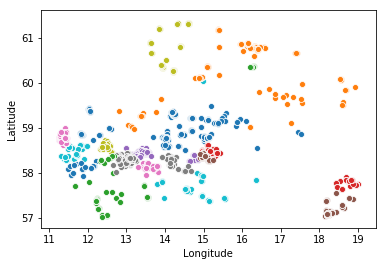

SE2


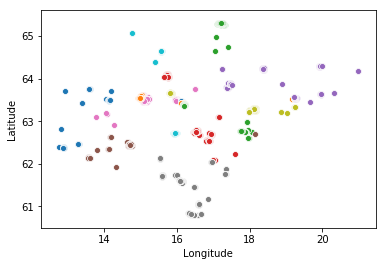

SE4


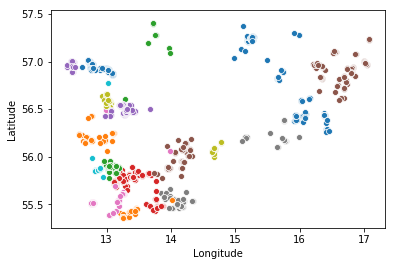

SE1


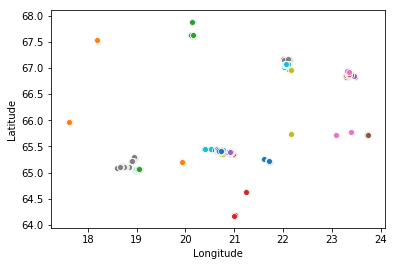

In [129]:
for region in clusters_region:
    se4 = df_2.loc[df_2['Price region'] == region].reset_index(drop = True)
    clusters = clusters_region[region]
    se4['clusters'] = 0
    for i,c in enumerate(clusters) : 
        clusterss[i] = clusters[i]
        se4.loc[se4.index.isin(clusters[i]), 'clusters'] = i  
    print(region)
    for c in se4.clusters.unique():
        y = se4.loc[se4.clusters == c].Latitude 
        x = se4.loc[se4.clusters == c].Longitude
        sizes = se4.loc[se4.clusters == c]['Max power [MW]']
        sns.scatterplot(x,y, label = c,  marker = 'o', legend = False )
    plt.show()

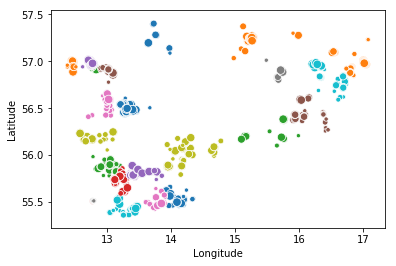

In [147]:
for c in se3.clusters.unique():
    y = se4.loc[se4.clusters == c].Latitude 
    x = se4.loc[se4.clusters == c].Longitude
    sizes = se4.loc[se4.clusters == c]['Max power [MW]']
    sns.scatterplot(x,y,size = sizes, marker = 'o' , legend = False)
plt.show()

In [199]:
import pickle
pickle.dump(clusters_region, open('clusters_region.pickle', 'wb'))
pickle.dump(centers_region, open('centers_region.pickle', 'wb'))

## Dimensionality reduction

### Step 0 : get all NWP grid points coordinates

#### random file extraction

In [4]:

fs_s3 = s3fs.S3FileSystem(anon=True)
s3path = "greenlytics-public/forecasting-competition/releases/Task0/{}/2000{}{}T00Z.nc".format('02', '02', '13')
remote_file_obj = fs_s3.open(s3path, mode="rb")
ds = xr.open_dataset(remote_file_obj, engine="h5netcdf")

#### grid coordinates extraction

In [9]:
keys = ds.to_dataframe().groupby(['latitude','longitude']).groups.keys()

In [12]:
grid_coords = pd.DataFrame(np.array(list(keys)), columns = ['latitude','longitude'])

### Step 1 : select points in squares around each region

In [10]:
regions_square = {}
for r in df_2['Price region'].unique() :
    df_r = df_2.loc[df_2['Price region'] == r]
    regions_square[r]  = [df_r.Latitude.min(), df_r.Latitude.max() ,  df_r.Longitude.min(), df_r.Longitude.max()]

In [18]:



def custom_func_2(x):
    res = 0
    for r in regions_square : 
        if x['latitude'] > regions_square[r][0] and x['latitude'] < regions_square[r][1] and x['longitude'] > regions_square[r][2] and x['longitude'] < regions_square[r][3] : 
            res = 1
            break
    return res


In [20]:
grid_coords['in_points'] = grid_coords.apply(custom_func_2, axis = 1) 

In [21]:
grid_coords.in_points.value_counts()

0    6549
1    5450
Name: in_points, dtype: int64

#### DR (dimensionality reduction) at step 1 : 11999 pts -> 5450 pts

### step 2 : Random selection of $n$ points in a 60 km circle around each cluster center previously defined

In [200]:
turbine_loc_to_keep = {region : np.array(centers_region[region])[:,[1,2]] for region in centers_region}

locations_to_keep = np.concatenate([turbine_loc_to_keep[region] for region in turbine_loc_to_keep ])

locations_to_keep.shape

(91, 2)

In [ ]:
grid_coords_right = grid_coords.loc[grid_coords['in_points'] == 1].reset_index(drop = True ).drop(columns = ['in_points'] )


In [ ]:
turbines_coords = df_2[[ 'Wind turbine ID','Longitude', 'Latitude']].values
NWP_points_coords = grid_coords_right[['longitude', 'latitude']].values

distance_matrix = np.array([[0 for x in turbines_coords] for y in NWP_points_coords])

In [45]:

turbines_coords = df_2[[ 'Wind turbine ID','Longitude', 'Latitude']].values
NWP_points_coords = grid_coords_right[['longitude', 'latitude']].values

distance_matrix = np.array([[0 for x in turbines_coords] for y in NWP_points_coords])

NWP_points_coords = grid_coords_right[['longitude', 'latitude']]

In [226]:
NWP_points_coords = grid_coords_right[['longitude', 'latitude']]


In [ ]:
turbine_loc_to_keep = {region : np.array(centers_region[region])[:,[1,2]] for region in centers_region}

locations_to_keep = np.concatenate([turbine_loc_to_keep[region] for region in turbine_loc_to_keep ])

locations_to_keep.shape

In [ ]:
warnings.filterwarnings("ignore")

turbine_loc_to_keep = {region : np.array(centers_region[region])[:,[1,2]] for region in centers_region}

centers_region_NWP_points = {region : {i : [center] for i,center in enumerate(turbine_loc_to_keep[region]) } for region in turbine_loc_to_keep }

NWP_points_coords = grid_coords_right[['longitude', 'latitude']]

n_points = 5

t0 = time.time()

for region in centers_region_NWP_points :
    for cluster_center in centers_region_NWP_points[region]:
        cluster_center_loc = centers_region_NWP_points[region][cluster_center][0]
        
        distances = [geodesic(tuple([cluster_center_loc[0],cluster_center_loc[1]]), tuple([y[1],y[0]])).km for y in NWP_points_coords.values ]
        NWP_points_coords['distance'] = distances
        NWP_points_coords['inball'] = NWP_points_coords['distance'] < 60
        nb_points = NWP_points_coords['inball'].sum()
        nb_points_to_keep = min(nb_points, n_points)
        NWP_points_to_keep_index = np.random.choice(NWP_points_coords.loc[NWP_points_coords.inball == True].sort_values(['distance']).index,nb_points_to_keep)
        NWP_points_to_keep = NWP_points_coords.loc[NWP_points_to_keep_index][['latitude','longitude']].values
        centers_region_NWP_points[region][cluster_center].append(NWP_points_to_keep)
        
        print(time.time() - t0)
    


#### $n$ = 10 points per windfarm

(201, 2) (230, 2)
(206, 2) (230, 2)
(177, 2) (230, 2)
(182, 2) (220, 2)


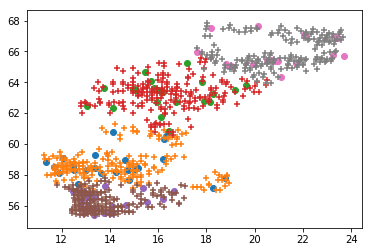

In [318]:
for region in centers_region_NWP_points :
    cluster_centers = []
    cluster_NWP_points = []
    for cluster_center in centers_region_NWP_points[region]:
        cluster_center_loc = centers_region_NWP_points[region][cluster_center][0]
        cluster_center_NWP_points = centers_region_NWP_points[region][cluster_center][1]
        cluster_centers.append (cluster_center_loc)
        cluster_NWP_points.append(cluster_center_NWP_points)
    
    cluster_NWP_points_2 = np.array(cluster_NWP_points).reshape((cluster_center+1)*10,2)
    cluster_centers = np.array(cluster_centers)
    cluster_NWP_points_2_unique = np.array(([np.array(i) for i in set(tuple(i) for i in cluster_NWP_points_2)]))
    print(cluster_NWP_points_2_unique.shape, cluster_NWP_points_2.shape)
    plt.scatter(cluster_centers[:,1], cluster_centers[:,0], marker='o' )
    plt.scatter(cluster_NWP_points_2_unique[:,1], cluster_NWP_points_2_unique[:,0], marker='+' )
    

#### $n$  = 5 points per windfarm (choosen value)

(107, 2) (115, 2)
(108, 2) (115, 2)
(101, 2) (115, 2)
(95, 2) (110, 2)


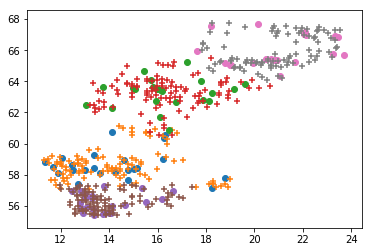

In [320]:
for region in centers_region_NWP_points :
    cluster_centers = []
    cluster_NWP_points = []
    for cluster_center in centers_region_NWP_points[region]:
        cluster_center_loc = centers_region_NWP_points[region][cluster_center][0]
        cluster_center_NWP_points = centers_region_NWP_points[region][cluster_center][1]
        cluster_centers.append (cluster_center_loc)
        cluster_NWP_points.append(cluster_center_NWP_points)
    
    cluster_NWP_points_2 = np.array(cluster_NWP_points).reshape((cluster_center+1)*5,2)
    cluster_centers = np.array(cluster_centers)
    cluster_NWP_points_2_unique = np.array(([np.array(i) for i in set(tuple(i) for i in cluster_NWP_points_2)]))
    print(cluster_NWP_points_2_unique.shape, cluster_NWP_points_2.shape) #some overlapping points
    plt.scatter(cluster_centers[:,1], cluster_centers[:,0], marker='o' )
    plt.scatter(cluster_NWP_points_2_unique[:,1], cluster_NWP_points_2_unique[:,0], marker='+' )

#### DR (dimensionality reduction) at step 2: 11999 pts -> ~500 pts

In [573]:
pickle.dump(NWP_locations_per_region, open( 'NWP_locations_per_region.pickle', 'wb'))

In [574]:
pickle.dump(centers_region_NWP_points, open( 'centers_region_NWP_points.pickle', 'wb'))

## Data download and selection of lines of interest

### Training Data

* There are 12 months of hourly data available in 2000 
* This step is time consuming (~30 sec per day extracted) , we keep arbritrarily : 
    * 4 months out of 12
    * 6 days per month
    * 24 hours per day 
    * features average over the 10 ensembles
    * only data points selected after dimensionality reduction, e.g. 5 random points around each key locations(max 60 km radius) 
    

In [504]:
import time
months = ['12', '08', '05', '03']

days = ['02', '04', '09', '15', '25', '20']


cols_to_keep = ['Temperature', 'RelativeHumidity', 'Wind_U', 'Wind_V', 'Pressure',
           'CloudCover', 'WindGustSpeed', 'latitude', 'longitude']

wether_per_day_train = {month + day : [] for month in months for day in days }

for month in months:
    time_day = time.time()
    for day in days : 
        
        s3path = "greenlytics-public/forecasting-competition/releases/Task0/{}/2000{}{}T00Z.nc".format(month, month, day)
        remote_file_obj = fs_s3.open(s3path, mode="rb")
        ds = xr.open_dataset(remote_file_obj, engine="h5netcdf")
        ds2 = ds.mean('ensemble_member').to_dataframe()
        ds2['concat_loc'] = np.round(ds2['latitude'],1).astype(str) + '_'+ np.round(ds2['longitude'],1).astype(str)

        times = pd.to_datetime(np.array(ds['time']))

        day_wether_per_region = {}

        for region in NWP_locations_per_region:

            loc = pd.DataFrame(np.round(NWP_locations_per_region[region],1), columns = ['latitude', 'longitude'])
            loc['concat_loc'] = loc['latitude'].astype(str) + '_'+ loc['longitude'].astype(str) 


            day_activity = {timestamps.hour : ds2.loc[ds2['concat_loc'].isin(loc['concat_loc'])].loc[[timestamps]][cols_to_keep].values for timestamps in times}

            day_wether_per_region[region] = day_activity
            
        wether_per_day_train[month+day] = day_wether_per_region
        print('time  = {} for day : {}'.format(time.time() - time_day, day + " / " + month))
        
    

time  = 37.2915620803833 for day : 02 / 12
time  = 68.27287793159485 for day : 04 / 12
time  = 101.39582419395447 for day : 09 / 12
time  = 133.80699229240417 for day : 15 / 12
time  = 164.617919921875 for day : 25 / 12
time  = 196.8690583705902 for day : 20 / 12
time  = 37.52636456489563 for day : 02 / 08
time  = 73.37482786178589 for day : 04 / 08
time  = 109.48364901542664 for day : 09 / 08
time  = 140.44319224357605 for day : 15 / 08
time  = 174.2305417060852 for day : 25 / 08
time  = 205.36619067192078 for day : 20 / 08
time  = 30.338218450546265 for day : 02 / 05
time  = 61.795098543167114 for day : 04 / 05
time  = 96.10249376296997 for day : 09 / 05
time  = 128.25759434700012 for day : 15 / 05
time  = 141.0635838508606 for day : 25 / 05
time  = 175.2628493309021 for day : 20 / 05
time  = 34.151973247528076 for day : 02 / 03
time  = 64.44542169570923 for day : 04 / 03
time  = 96.47880601882935 for day : 09 / 03
time  = 131.5109086036682 for day : 15 / 03
time  = 162.1343462467193

In [506]:
pickle.dump(wether_per_day_train, open( 'wether_per_day_train.pickle', 'wb'))

In [516]:
s3path = "greenlytics-public/forecasting-competition/releases/Task1/{}/2001{}{}T00Z.nc".format('02', '02', '27')
remote_file_obj = fs_s3.open(s3path, mode="rb")
ds = xr.open_dataset(remote_file_obj, engine="h5netcdf")

### Task 1 data 

In [517]:
import time
months = ['02']

days = ['01','02','03', '04','05','06','07','08' ,'09']
days_january =  [str(i) for i in range (10,32)]
days_february = [str(i) for i in range (27,29)] #not bisextile

cols_to_keep = ['Temperature', 'RelativeHumidity', 'Wind_U', 'Wind_V', 'Pressure',
           'CloudCover', 'WindGustSpeed', 'latitude', 'longitude']


for month in months:
    time_day = time.time()
    days_month = []
    if month == '01' :
        days_month = days + days_january
    else : 
        days_month = days_february
    for day in days_month : 
        
        s3path = "greenlytics-public/forecasting-competition/releases/Task1/{}/2001{}{}T00Z.nc".format(month, month, day)
        remote_file_obj = fs_s3.open(s3path, mode="rb")
        ds = xr.open_dataset(remote_file_obj, engine="h5netcdf")
        ds2 = ds.mean('ensemble_member').to_dataframe()
        ds2['concat_loc'] = np.round(ds2['latitude'],1).astype(str) + '_'+ np.round(ds2['longitude'],1).astype(str)

        times = pd.to_datetime(np.array(ds['time']))

        day_wether_per_region = {}

        for region in NWP_locations_per_region: ## only keep ~200 points per region
            
            loca = pd.DataFrame(np.round(NWP_locations_per_region[region],1), columns = ['latitude', 'longitude'])
            loca['concat_loc'] = loca['latitude'].astype(str) + '_'+ loca['longitude'].astype(str) 


            day_activity = {timestamps.hour : ds2.loc[ds2['concat_loc'].isin(loca['concat_loc'])].loc[[timestamps]][cols_to_keep].values for timestamps in times}

            day_wether_per_region[region] = day_activity
            
        wether_per_day_test[month+day] = day_wether_per_region
        print('time  = {} for day : {}'.format(time.time() - time_day, day + " / " + month))
        
    

time  = 11.259990453720093 for day : 27 / 02
time  = 41.807517528533936 for day : 28 / 02


In [137]:
wether_per_day_test = pickle.load(open('wether_per_day_test.pickle','rb'))

## Clean data_train & data_test

### recovering X_train

In [554]:
import datetime
data_train = pd.DataFrame([])

for day in wether_per_day_3:
    
    for region in wether_per_day_3[day] :
        
        for hour in wether_per_day_3[day][region]:
            
            data_day_hour = pd.DataFrame(wether_per_day_3[day][region][hour], columns = cols_to_keep)
            date = np.datetime64(datetime.datetime(2000,int(day[:2]),int(day[2:4]), hour))
            
            data_day_hour['region'] = region
            data_day_hour['date'] = date
            
            data_train = pd.concat([data_train, data_day_hour])
            

### recovering y_train

In [1113]:
df = pd.read_csv('windpower_task6.csv')

In [1114]:
df['date'] = pd.to_datetime(df['Unnamed: 0'])
df.drop(columns = 'Unnamed: 0', inplace = True)

In [1115]:
def to_date(x):
    return np.datetime64(x)

df.date = df.date.apply(to_date)

In [622]:
data_train['y'] = 0 

dates = data_train.date.unique()
regions = data_train.region.unique()
df['y'] = 0 

for date in dates:
    
    for region in regions : 
        
        data_train.loc[(data_train.date == date ) & (data_train.region == region ), 'y'] = df.loc[df.date == date][region].values[0]

In [624]:
data_train.y.min(), data_train.y.max()

(1.7228599999999998, 1935.9707019999998)

In [767]:
pickle.dump(data_test, open( 'data_test.pickle', 'wb'))

### recovering X_test / y_test

In [760]:
import datetime
data_test = pd.DataFrame([])

for day in wether_per_day_test:
    
    for region in wether_per_day_test[day] :
        
        for hour in wether_per_day_test[day][region]:
            
            data_day_hour = pd.DataFrame(wether_per_day_test[day][region][hour], columns = cols_to_keep)
            date = np.datetime64(datetime.datetime(2001,int(day[:2]),int(day[2:4]), hour))
            
            data_day_hour['region'] = region
            data_day_hour['date'] = date
            
            data_test = pd.concat([data_test, data_day_hour])

In [ ]:
def add_year(x):
    return np.datetime64(datetime.datetime(2001,x.month,x.day, x.hour))

In [208]:
data_test.date = data_test.new_date
data_test.drop(columns = 'new_date', inplace = True)

In [210]:
data_test['y'] = 0 

dates = data_test.date.unique()
regions = data_test.region.unique()
df['y'] = 0 

for date in dates:
    
    for region in regions : 
        
        data_test.loc[(data_test.date == date ) & (data_test.region == region ), 'y'] = df.loc[df.date == date][region].values[0]

## Feature engineering

In [523]:
def wind_vertical_shift(x):
    return x*(1/1000)**(1/7)

In [565]:
def wind_power_density(x):
    return (1/2)*x['Moist_air_density']*(x['WindHubHeight']**3)

In [563]:
def moist_air_density(x):
    temp_celcius = x['Temperature'] - 273.15
    p1 = 6.1078 * 10**((7.5 *temp_celcius) /(temp_celcius + 237.3))
    pv = p1* x['RelativeHumidity']
    pd = x['Pressure'] - pv
    Rd = 287.058 
    Rv = 461.495
    return (pd / (Rd * x['Temperature'])) + (pv / (Rv * x['Temperature']))

In [566]:
data_train['WindHubHeight'] = data_train['WindGustSpeed'].apply(wind_vertical_shift)
data_train['Moist_air_density'] = data_train.apply(moist_air_density, axis =1)
data_train['Wind_power_density'] = data_train.apply(wind_power_density, axis =1)

In [700]:
data_train['hour'] = data_train['date'].apply(lambda x : x.hour )
data_train['weekday'] = data_train['date'].apply(lambda x : x.weekday() )

In [763]:
data_test['WindHubHeight'] = data_test['WindGustSpeed'].apply(wind_vertical_shift)
data_test['Moist_air_density'] = data_test.apply(moist_air_density, axis =1)
data_test['Wind_power_density'] = data_test.apply(wind_power_density, axis =1)

In [762]:
data_test['hour'] = data_test['date'].apply(lambda x : x.hour )
data_test['weekday'] = data_test['date'].apply(lambda x : x.weekday() )

In [705]:
data_train

,Temperature,RelativeHumidity,Wind_U,Wind_V,Pressure,CloudCover,WindGustSpeed,latitude,longitude,region,date,WindHubHeight,Moist_air_density,Wind_power_density,y,approx_y,concat_loc,hour,weekday
0,278.300507,0.987112,-1.232249,1.858926,99000.328125,1.000000,5.604048,58.907552,11.306673,SE3,2000-12-02 00:00:00,2.088961,1.239192,5.648066,769.510520,481.986779,58.9_11.3,0,5
1,279.504761,0.972705,-2.254466,8.027286,99076.609375,1.000000,11.479038,57.659418,11.608369,SE3,2000-12-02 00:00:00,4.278919,1.234801,48.369217,769.510520,481.986779,57.7_11.6,0,5
2,279.486511,0.971475,-2.040501,7.626895,99070.390625,1.000000,10.794477,57.748862,11.599520,SE3,2000-12-02 00:00:00,4.023743,1.234804,40.221527,769.510520,481.986779,57.7_11.6,0,5
3,277.795349,0.997830,-1.208030,1.938126,99031.382812,1.000000,5.881888,58.733441,11.499043,SE3,2000-12-02 00:00:00,2.192529,1.241836,6.544405,769.510520,481.986779,58.7_11.5,0,5
4,277.830292,0.986579,-1.838938,1.724356,99025.859375,1.000000,5.937956,59.002164,11.470602,SE3,2000-12-02 00:00:00,2.213429,1.241611,6.732124,769.510520,481.986779,59.0_11.5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,270.785736,0.824020,6.032301,-1.885641,99690.929688,0.346927,8.380053,65.575617,23.224578,SE1,2000-03-20 23:00:00,3.123743,1.282488,19.545608,160.663856,288.549556,65.6_23.2,23,0
118,267.817627,0.902859,3.604762,-0.650631,99669.796875,0.432925,5.604637,65.753803,23.280378,SE1,2000-03-20 23:00:00,2.089181,1.296429,5.910808,160.663856,288.549556,65.8_23.3,23,0
119,267.011902,0.954884,2.674489,-0.706979,99660.679688,0.505380,4.768964,65.842878,23.308561,SE1,2000-03-20 23:00:00,1.777676,1.300222,3.652122,160.663856,288.549556,65.8_23.3,23,0
120,266.237122,0.952321,2.610719,-0.817526,99636.312500,0.745386,4.580085,66.110028,23.394267,SE1,2000-03-20 23:00:00,1.707270,1.303688,3.243770,160.663856,288.549556,66.1_23.4,23,0


## PCA / analog_based_approach

In [770]:
PCA_matrix_regions_train = {region : [] for region in data_train.region.unique()}
PCA_matrix_regions_test = {region : [] for region in data_train.region.unique()}

points_per_region = {region : data_train.loc[(data_train.date ==  data_train.date.unique()[400]) &  ( data_train.region == region )  ].shape[0] for region in data_train.region.unique()} 

dates_train = data_train.date.unique()
dates_test = data_test.date.unique()

cols_PCA = ['WindHubHeight']

for region in PCA_matrix_regions_train :
    PCA_matrix_train = np.zeros(shape= (dates_train.shape[0], points_per_region[region] * len(cols_PCA)))
    PCA_matrix_test = np.zeros(shape= (dates_test.shape[0], points_per_region[region] * len(cols_PCA)))
    
    for i,date in  enumerate(dates_train) : 
    
        data_day = data_train.loc[(data_train.date == date) & (data_train.region == region)][cols_PCA].values.flatten()
        PCA_matrix_train[i] = data_day
        
    
    for i,date in  enumerate(dates_test) : 
    
        data_day = data_test.loc[(data_test.date == date) & (data_test.region == region)][cols_PCA].values.flatten()
        PCA_matrix_test[i] = data_day
        
        
    PCA_matrix_regions_train[region] = PCA_matrix_train
    PCA_matrix_regions_test[region] = PCA_matrix_test

In [771]:
from sklearn.decomposition import PCA

PCA_matrix_regions_fitted_train = {region : [] for region in PCA_matrix_regions_train}
PCA_matrix_regions_fitted_test = {region : [] for region in PCA_matrix_regions_train}

for region in PCA_matrix_regions_train :
    
    X_before_train = PCA_matrix_regions_train[region]
    X_before_test = PCA_matrix_regions_test[region]

    pca = PCA(n_components=10)
    
    X_after_train = pca.fit_transform(X_before_train)
    X_before_test = pca.transform(X_before_test)
    
    PCA_matrix_regions_fitted_train[region] = X_after_train
    PCA_matrix_regions_fitted_test[region] = X_before_test
    
    print(np.cumsum(pca.explained_variance_ratio_))

[0.65807252 0.76291716 0.83777927 0.87764525 0.90748457 0.92463063
 0.93545924 0.9433629  0.94977257 0.95449636]
[0.69724376 0.78596517 0.83124151 0.86447545 0.88677854 0.90497154
 0.91779447 0.92913658 0.93797545 0.94494514]
[0.78659028 0.86096115 0.89659758 0.92956634 0.94517348 0.95430634
 0.96104923 0.96641634 0.97135293 0.97461929]
[0.64413539 0.76039551 0.82671973 0.86746209 0.89902118 0.91952996
 0.93365573 0.93992928 0.94585066 0.95119919]


In [ ]:
24*30*12

In [772]:

euc_distances = scipy.spatial.distance.cdist(PCA_matrix_regions_fitted_test[region], PCA_matrix_regions_fitted_train[region])
    

In [774]:
euc_distances.shape

(1224, 576)

In [776]:
import scipy 

data_train['approx_y'] = 0
data_test['approx_y'] = 0

for region in PCA_matrix_regions_fitted :
    
    euc_distances_train = scipy.spatial.distance.cdist(PCA_matrix_regions_fitted_train[region], PCA_matrix_regions_fitted_train[region])
    euc_distances_test = scipy.spatial.distance.cdist(PCA_matrix_regions_fitted_test[region], PCA_matrix_regions_fitted_train[region])

    for i,date in enumerate(dates_train): 
        
        euc_distance_date = euc_distances_train[:,i]
        closest_dates = dates_train[np.argsort(euc_distance_date)[1:5]]
        
        y_close = data_train.loc[(data_train.date.isin(closest_dates)) & (data_train.region == region)].y.unique()
        
        data_train.loc[(data_train.date.isin(closest_dates)) & (data_train.region == region), 'approx_y'] = np.mean(y_close)
    
    for i,date in enumerate(dates_test): 
        
        euc_distance_date = euc_distances_test[i,:]
        closest_dates = dates_test[np.argsort(euc_distance_date)[1:5]]
        
        y_close = data_test.loc[(data_test.date.isin(closest_dates)) & (data_test.region == region)].y.unique()
        
        data_test.loc[(data_test.date.isin(closest_dates)) & (data_test.region == region), 'approx_y'] = np.mean(y_close)

### X_train, y_train

In [212]:
centers_region_NWP_points = pickle.load(open('centers_region_NWP_points.pickle', 'rb'))

In [213]:
region_centers_loc = {region : [] for region in regions }

for region in regions : 
    region_centers = np.concatenate([[centers_region_NWP_points[region][i][0]] for i in range(22)] )
    loc = pd.DataFrame(np.round(region_centers, 1), columns = ['latitude', 'longitude'])
    
    loc['concat_loc'] = loc['latitude'].astype(str) + '_'+ loc['longitude'].astype(str) 
    data_train['concat_loc'] = np.round(data_train['latitude'],1).astype(str) + '_'+ np.round(data_train['longitude'],1).astype(str)

    region_centers_loc[region] = data_train.loc[(data_train['concat_loc'].isin(loc['concat_loc']))].concat_loc.unique()


In [214]:
region_centers_loc

{'SE3': array(['58.5_11.7', '58.1_11.9', '58.6_12.5', '58.4_13.4', '59.3_13.4',
        '58.1_13.6', '58.2_14.3', '59.0_14.6', '57.7_14.8', '58.3_14.8',
        '58.4_15.0', '59.0_16.2', '57.1_18.3', '57.8_18.8'], dtype=object),
 'SE2': array(['64.7_15.4', '63.7_15.8', '62.7_15.9', '63.5_16.0', '61.7_16.1',
        '63.4_16.2', '64.0_17.8', '62.8_17.9', '62.7_18.1', '63.5_19.2',
        '63.8_19.6'], dtype=object),
 'SE4': array(['57.0_12.5', '55.5_12.9', '56.5_13.0', '56.6_13.0', '56.8_13.0',
        '55.4_13.4', '56.5_13.3', '56.6_13.3', '57.3_13.8', '55.5_14.0'],
       dtype=object),
 'SE1': array(['66.0_17.6', '67.5_18.2', '65.2_18.8', '65.0_19.0', '65.1_19.0',
        '67.7_20.1', '65.2_19.9', '65.4_20.8', '65.4_21.0', '67.0_22.1',
        '67.1_22.1', '67.2_22.1', '65.8_23.3'], dtype=object)}

In [ ]:
pickle.dump(region_centers_loc , open('region_centers_loc.pickle', 'wb'))

In [755]:
coi_reg = ['WindHubHeight', 'Moist_air_density' , 'Wind_power_density' , 'Wind_U', 'Wind_V' ]
other_coi_reg = ['hour', 'weekday', 'approx_y']

n_key_locations = 10 

X_trains = {region : [] for region in regions }
y_trains = {region : [] for region in regions }

for region in PCA_matrix_regions_fitted :
    X_train = np.zeros(shape = (dates.shape[0], len(other_coi_reg) + len(coi_reg)*n_key_locations ))
    y_train = np.zeros(shape = (dates.shape[0],))
    key_locations = region_centers_loc[region][:n_key_locations]
                             
    for i,date in enumerate(dates) : 
        
        data_hour = data_train.loc[(data_train.date == date) & (data_train.region == region) ]
        
        X_train[i,:len(other_coi_reg)] = data_hour.iloc[[0]][other_coi_reg].values
        X_train[i,len(other_coi_reg):] = data_hour.loc[data_hour.concat_loc.isin(key_locations)].sort_values('WindGustSpeed', ascending = False).iloc[:10][coi_reg].values.flatten()
        y_train[i]    = data_hour.y.unique()
        
    X_trains[region] = X_train
    y_trains[region] = y_train

### some values of y_analog vs y_true 

#### n = 50 

In [753]:
X_train[10:20,2] ,  y_train[10:20]

(array([334.06219167, 334.06219167, 334.06219167, 334.06219167,
        334.06219167, 290.52456912, 290.52456912, 290.52456912,
        290.52456912, 287.17701602]),
 array([452.190419, 435.938276, 437.028995, 411.755981, 400.542644,
        383.343753, 392.223568, 389.291711, 397.373114, 396.236341]))

#### n = 4

In [756]:
X_train[10:20,2] ,  y_train[10:20]

(array([431.4250835 , 431.4250835 , 406.08807425, 398.453476  ,
        392.6378055 , 392.294194  , 388.31681825, 388.31681825,
        342.00189125, 342.00189125]),
 array([452.190419, 435.938276, 437.028995, 411.755981, 400.542644,
        383.343753, 392.223568, 389.291711, 397.373114, 396.236341]))

### X_test , y_test

In [216]:
data_test['concat_loc'] = np.round(data_test['latitude'],1).astype(str) + '_'+ np.round(data_test['longitude'],1).astype(str)

In [219]:
coi_reg = ['WindHubHeight', 'Moist_air_density' , 'Wind_power_density' , 'Wind_U', 'Wind_V' ]
other_coi_reg = ['hour', 'weekday', 'approx_y']

n_key_locations = 10 
dates_test = data_test.date.unique()

X_tests = {region : [] for region in regions }
y_tests = {region : [] for region in regions }


for region in regions :
    X_test = np.zeros(shape = (dates.shape[0], len(other_coi_reg) + len(coi_reg)*n_key_locations ))
    y_test = np.zeros(shape = (dates.shape[0],))
    key_locations = region_centers_loc[region][:n_key_locations]
                             
    for i,date in enumerate(dates_test) : 
        
        data_hour = data_test.loc[(data_test.date == date) & (data_test.region == region) ]
        
        X_test[i,:len(other_coi_reg)] = data_hour.iloc[[0]][other_coi_reg].values
        X_test[i,len(other_coi_reg):] = data_hour.loc[data_hour.concat_loc.isin(key_locations)].sort_values('WindGustSpeed', ascending = False).iloc[:10][coi_reg].values.flatten()
        y_test[i]    = data_hour.y.unique()
        
    X_tests[region] = X_test
    y_tests[region] = y_test

In [784]:
X_test[10:20,2] ,  y_test[10:20]

(array([189.6381285 , 124.5652085 ,  75.03140375,  76.240753  ,
         75.03140375,  75.03140375,  75.03140375,  77.46201775,
         74.50755325,  43.291652  ]),
 array([124.48137 , 107.626047,  93.693984,  78.974196,  66.532664,
         65.762168,  74.136799,  84.390178,  84.78843 ,  78.413883]))

### Training

In [21]:
import pickle 

train_test_data = pickle.load( open( 'train_test_data.pickle', "rb" ) )
data_train = pickle.load( open( 'data_train.pickle', "rb" ) )
data_test = pickle.load( open( 'data_test.pickle', "rb" ) )

X_trains, y_trains, X_tests , y_tests = train_test_data[0] , train_test_data[1] , train_test_data[2] , train_test_data[3] 

In [84]:
regions = data_train.region.unique()
region = regions[2]

In [227]:
from sklearn.ensemble import GradientBoostingRegressor

alpha = .01

clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=25, max_depth=3,
                                learning_rate=1, min_samples_leaf=9,
                                min_samples_split=9)


In [ ]:

dates_test = pd.to_datetime(data_test.date.unique())

In [1005]:

from sklearn.ensemble import GradientBoostingRegressor

lower_bounds_region = {region : [] for region in regions}

for region in regions : 
    
    Xtrain = X_trains[region]

    Xtrain = Xtrain[:,:-1]

    ytrain = y_trains[region]

    Xtask = X_tests[region]
    Xtask = Xtask[:,:-1]

    alphas = [.1, .2,.3,.4,.5,.6,.7,.8,.9]
    lower_bounds = {alpha : [] for alpha in alphas}

    for alpha in lower_bounds:


        clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                        n_estimators=180, max_depth=10,
                                        learning_rate=0.05, min_samples_leaf=10,
                                        min_samples_split=8)

        clf.fit(Xtrain, ytrain *1.3)

        y_alpha = clf.predict(Xtask) 

        lower_bounds[alpha] = y_alpha
        
    lower_bounds_region[region] = lower_bounds


#### Target engineering

In [1006]:

regions_factors = [4,4,4,7]
loading_factors = {region : regions_factors[i] for i, region in enumerate(regions)}

def update_lower_bounds(loading_factors, lower_bounds_eng) :
    
    lower_bounds_eng_region = {region: [] for region in regions }

    for region in regions :

        lower_bounds_eng = {alpha : [] for alpha in alphas}

        lf = loading_factors[region]
        for alpha in lower_bounds_eng:
            if lf > 1 :
                loading_factor = np.arange(1,lf,(lf-1)/(dates_test.shape[0]))

                lower_bounds_eng[alpha] = lower_bounds_region[region][alpha] * loading_factor / 1000
            else : 
                lower_bounds_eng[alpha] = lower_bounds_region[region][alpha]  / 1000
                
        lower_bounds_eng_region[region] = lower_bounds_eng

        #print( lower_bounds_eng_region[region][alpha] )
        
    return lower_bounds_eng_region


In [118]:
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY,DAILY, HOURLY,  DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import numpy as np
import datetime

#### First result 

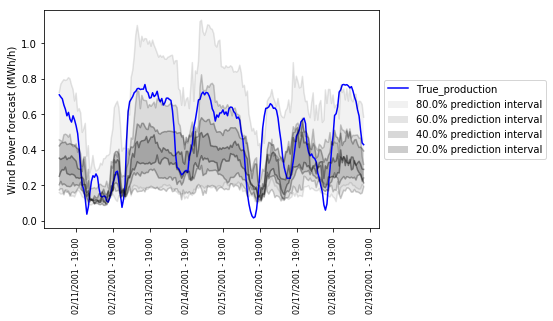

In [374]:
low = 800
upper = 1000

fig, ax = plt.subplots()

rule = rrulewrapper(DAILY)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%Y - %H:00 ')


ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=90, labelsize=8)
sns.lineplot(dates_test[low:upper], y_tests[region][low:upper] / 1000 , color = 'b', label='True_production')

for i in range(4) : 
    y_upper = lower_bounds_eng[alphas[-i -1]]
    y_lower = lower_bounds_eng[alphas[i]]
    
    plt.plot(dates_test[low:upper], y_upper[low:upper], 'k-', alpha=alphas[i])
    plt.plot(dates_test[low:upper], y_lower[low:upper], 'k-', alpha=alphas[i])
    plt.fill(np.concatenate([dates_test[low:upper], dates_test[low:upper][::-1]]),
             np.concatenate([y_upper[low:upper], y_lower[low:upper][::-1]]),
             alpha=alphas[i], fc='grey', ec='None', label='{}% prediction interval'.format(np.round((alphas[-i -1] - alphas[i])*100, 2)))
    #plt.xlabel('$x$')
    plt.ylabel('Wind Power forecast (MWh/h)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Team 12 submission (ranked 2nd in the competition $)^1$


Source code (in R), paper and data submited from team 12 available at : https://pureportal.strath.ac.uk/en/datasets/data-and-code-for-the-eem2020-wind-power-forecasting-competition



In [1119]:
df_task_1 = pd.read_csv('Team_12_sub_1.csv')
lower_bounds_eng_region_12 = {region : {alpha :  df_task_1['q{}_{}'.format(str(int(alpha * 100)) , region)].values / 1000 for alpha in alphas } for region in regions}
y_tests_12 = {region : df.loc[df.date.isin(dates_test)][region].values for region in regions}

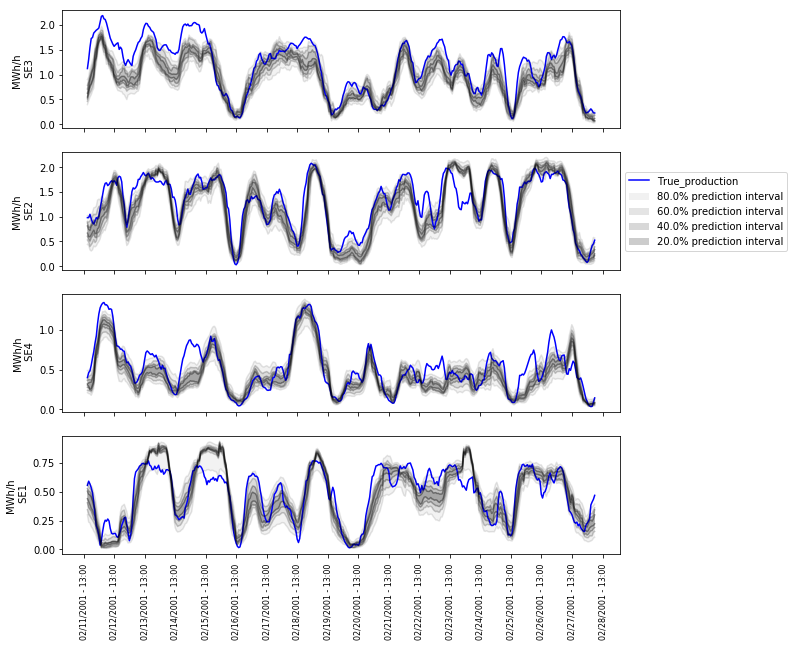

In [1124]:
low = 1000
upper = 1400

fig, ax = plt.subplots(regions.shape[0], 
           sharex='col', sharey='row',figsize = (10,10),)

rule = rrulewrapper(DAILY)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%Y - %H:00 ')

dates_test = pd.to_datetime(df_task_1.TIMESTAMP).unique()

for j, region in enumerate(regions):
    

    ax[j].xaxis.set_major_locator(loc)
    ax[j].xaxis.set_major_formatter(formatter)
    ax[j].xaxis.set_tick_params(rotation=90, labelsize=8)
    
    ax[j].plot(dates_test[low:upper], y_tests_12[region][low:upper] / 1000 , color = 'b', label='True_production')

    for i in range(4) :
        
        y_upper = lower_bounds_eng_region_12[region][alphas[-i -1]]
        y_lower = lower_bounds_eng_region_12[region][alphas[i]]

        ax[j].plot(dates_test[low:upper], y_upper[low:upper], 'k-', alpha=alphas[i])
        ax[j].plot(dates_test[low:upper], y_lower[low:upper], 'k-', alpha=alphas[i])
         
        ax[j].set( ylabel='MWh/h \n {}'.format(region))
        if j == 1 :
            ax[j].fill(np.concatenate([dates_test[low:upper], dates_test[low:upper][::-1]]),
                     np.concatenate([y_upper[low:upper], y_lower[low:upper][::-1]]),
                     alpha=alphas[i], fc='grey', ec='None', label='{}% prediction interval'.format(np.round((alphas[-i -1] - alphas[i])*100, 2)))
            #plt.xlabel('$x$')
            ax[j].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else : 
            ax[j].fill(np.concatenate([dates_test[low:upper], dates_test[low:upper][::-1]]),
                     np.concatenate([y_upper[low:upper], y_lower[low:upper][::-1]]),
                     alpha=alphas[i], fc='grey', ec='None')
            

### Basline results using ~50Mo NWP data retrieved from >20Go available for the training

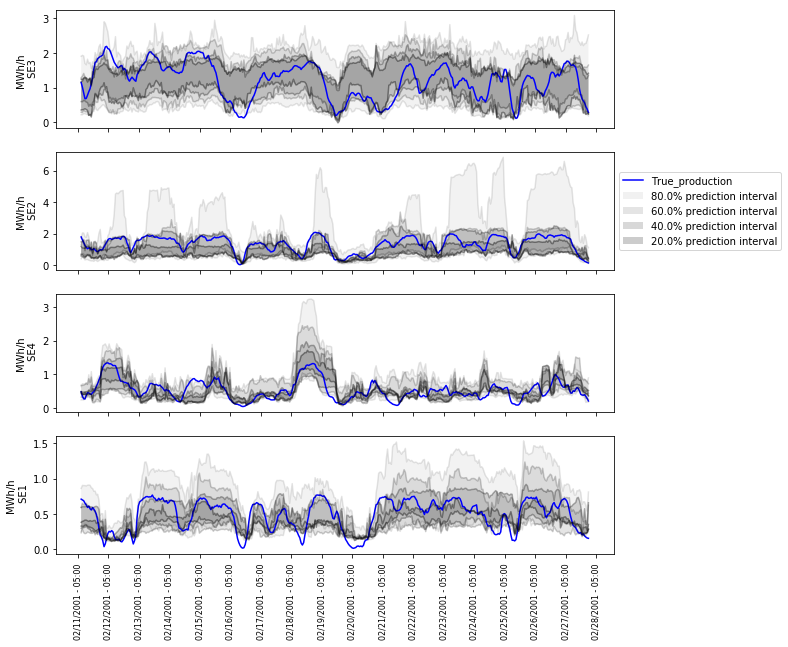

In [1123]:
low = 800
upper = 1200

fig, ax = plt.subplots(regions.shape[0], 
           sharex='col', sharey='row',figsize = (10,10),)

rule = rrulewrapper(DAILY)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%Y - %H:00 ')

dates_test = data_test.date.unique()

for j, region in enumerate(regions):
    

    ax[j].xaxis.set_major_locator(loc)
    ax[j].xaxis.set_major_formatter(formatter)
    ax[j].xaxis.set_tick_params(rotation=90, labelsize=8)
    
    ax[j].plot(dates_test[low:upper], y_tests[region][low:upper] / 1000 , color = 'b', label='True_production')

    for i in range(4) :
        
        y_upper = lower_bounds_eng_region[region][alphas[-i -1]]
        y_lower = lower_bounds_eng_region[region][alphas[i]]

        ax[j].plot(dates_test[low:upper], y_upper[low:upper], 'k-', alpha=alphas[i])
        ax[j].plot(dates_test[low:upper], y_lower[low:upper], 'k-', alpha=alphas[i])
         
        ax[j].set( ylabel='MWh/h \n {}'.format(region))
        if j == 1 :
            ax[j].fill(np.concatenate([dates_test[low:upper], dates_test[low:upper][::-1]]),
                     np.concatenate([y_upper[low:upper], y_lower[low:upper][::-1]]),
                     alpha=alphas[i], fc='grey', ec='None', label='{}% prediction interval'.format(np.round((alphas[-i -1] - alphas[i])*100, 2)))
            #plt.xlabel('$x$')
            ax[j].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else : 
            ax[j].fill(np.concatenate([dates_test[low:upper], dates_test[low:upper][::-1]]),
                     np.concatenate([y_upper[low:upper], y_lower[low:upper][::-1]]),
                     alpha=alphas[i], fc='grey', ec='None')
            